# Deep Learning: Binary Classification
---
Guidelines: 
* Re-run the binary classification using the following configurations:
  * Use layers with more hidden units or less hidden units: 32 units, 64 units.
  * Use the mse loss function instead of binary_crossentropy.
  * Use the tanh activation (an activation that was popular in the early days of neural networks) instead of relu.

In [1]:
import os
import pickle
import warnings
import keras
import pandas as pd
import numpy as np
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.optimizers import RMSprop
from keras.datasets import imdb
from typing import Union, Type, TypeVar
from typing_extensions import Self
from matplotlib import pyplot as plt
from xgboost import XGBClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.compose import ColumnTransformer
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, auc
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, PolynomialFeatures

%matplotlib inline
%config InlineBackend.figure_format = "retina"
warnings.simplefilter('ignore')

2022-10-06 14:02:24.229272: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
/home/cabrera/anaconda3/envs/dsa/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


In [2]:
color_a1 = '#664c85'
color_a2 = '#5b92b6'
color_a3 = '#52d5bd'
color_a4 = '#eeeeee'
palette_a1 = 'mako'
palette_a2 = 'mako_r'

## Initialization

### The Internet Movie Database (IMDB) dataset
* A set of 50,000 highly-polarized reviews from the Internet Movie Database. 
* They are split into 25,000 reviews for training and 25,000 for testing, each set consisting of 50% negative and 50% positive reviews.

### Loading the dataset

Keeping only the top 10,000 frequently occuring words in the training data and have rare words discarded as to work with vector data of manageable size.

In [3]:
(var_X_train, var_y_train), (var_X_test, var_y_test) = imdb.load_data(
    num_words = 10000, start_char = 1, oov_char = 2, index_from = 3)

Data overview

In [4]:
print(f"X train shape: {var_X_train.shape}")
print(f"X test shape: {var_X_test.shape}")
print(f"y train shape: {var_y_train.shape}")
print(f"y test shape: {var_y_test.shape}")

X train shape: (25000,)
X test shape: (25000,)
y train shape: (25000,)
y test shape: (25000,)


In [5]:
var_X_train

array([list([1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17, 515, 17, 12, 16, 626, 18, 2, 5, 62, 386, 12, 8, 316, 8, 106, 5, 4, 2223, 5244, 16, 480, 66, 3785, 33, 4, 130, 12, 16, 38, 619, 5, 25, 124, 51, 36, 135, 48, 25, 1415, 33, 6, 22, 12, 215, 28, 77, 52, 5, 14, 407, 16, 82, 2, 8, 4, 107, 117, 5952, 15, 256, 4, 2, 7, 3766, 5, 723, 36, 71, 43, 530, 476, 26, 400, 317, 46, 7, 4, 2, 1029, 13, 104, 88, 4, 381, 15, 297, 98, 32, 2071, 56, 26, 141, 6, 194, 7486, 18, 4, 226, 22, 21, 134, 476, 26, 480, 5, 144, 30, 5535, 18, 51, 36, 28, 224, 92, 25, 104, 4, 226, 65, 16, 38, 1334, 88, 12, 16, 283, 5, 16, 4472, 113, 103, 32, 15, 16, 5345, 19, 178, 32]),
       list([1, 194, 1153, 194, 8255, 78, 228,

In [6]:
var_y_train

array([1, 0, 0, ..., 0, 1, 0])

Since we restricted ourselves to the top 10,000 most frequent words, no word index will exceed 10,000

In [7]:
max([max(sequence) for sequence in var_X_train])

9999

### Decoding reviews back to English words

Reversing the key-value pairs of the word index and marking [1] as the start of the sequence and [2] as an out-of-vocabulary character

In [8]:
word_index = imdb.get_word_index()
reverse_word_index = {word_id + 3: word for word,word_id in word_index.items()}
reverse_word_index.update({1: '[START]', 2: '[OOV]'})

Word index overview as a pandas dataframe

In [9]:
(pd.DataFrame(
    columns = ['word'], index = reverse_word_index.keys(), 
    data = reverse_word_index.values())
    .head(10))

,word
34704,fawn
52009,tsukino
52010,nunnery
16819,sonja
63954,vani
1411,woods
16118,spiders
2348,hanging
2292,woody
52011,trawling


Decoding a sequence

In [10]:
' '.join([reverse_word_index.get(i) for i in var_X_train[0]])

"[START] this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert [OOV] is an amazing actor and now the same being director [OOV] father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for [OOV] and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also [OOV] to the two little boy's that played the [OOV] of norman and paul they were just brilliant children are often left out of the [OOV] list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for wh

### Preparing the data
We cannot feed lists of integers into a neural network. We have to turn our lists into tensors. There are two ways we could do that:

* We could pad our lists so that they all have the same length, and turn them into an integer tensor of shape (samples, word_indices), then use as first layer in our network a layer capable of handling such integer tensors (the Embedding layer).
* We could one-hot-encode our lists to turn them into vectors of 0s and 1s. Concretely, this would mean for instance turning the sequence [3, 5] into a 10,000-dimensional vector that would be all-zeros except for indices 3 and 5, which would be ones. Then we could use as first layer in our network a Dense layer, capable of handling floating point vector data.

We will go with the latter solution. Let's vectorize our data, which we will do manually for maximum clarity:

In [11]:
def vectorize_sequences(sequences, dimension: int = 10_000) -> np.ndarray:
    # Create an all-zero matrix of shape (len(sequences), dimension)
    results = np.zeros((len(sequences), dimension))
    for i, sequence in enumerate(sequences):
        # Set specific indices of results[i] to 1s
        results[i, sequence] = 1.  
    return results

Vectorizing the data

In [12]:
var_X_train_vectorized = vectorize_sequences(var_X_train)
var_X_test_vectorized = vectorize_sequences(var_X_test)

In [13]:
var_y_train_vectorized = np.asarray(var_y_train).astype('float32')
var_y_test_vectorized = np.asarray(var_y_test).astype('float32')

## Execution

### Building our network

In [14]:
model = Sequential(layers = [
    Dense(units = 32, activation = 'tanh', input_shape = (10_000, )),
    Dense(units = 64, activation = 'tanh'),
    Dense(units = 1, activation = 'sigmoid'), ])

2022-10-06 14:03:42.851139: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 32)                320032    
                                                                 
 dense_1 (Dense)             (None, 64)                2112      
                                                                 
 dense_2 (Dense)             (None, 1)                 65        
                                                                 
Total params: 322,209
Trainable params: 322,209
Non-trainable params: 0
_________________________________________________________________


Configuring the model with the `rmsprop` optimizer, `mse` or mean squared error as the loss function, and monitoring the accuracy during training.

In [16]:
model.compile(optimizer = RMSprop(learning_rate = 0.001), loss = 'mse', metrics = ['accuracy'])

### Validating approach

In order to monitor during training the accuracy of the model on data that it has never seen before, we will create a "validation set" by setting apart 50% of the samples from the vectorized testing data.

In [17]:
var_X_test_vectorized, var_X_val_vectorized, var_y_test_vectorized, var_y_val_vectorized = (
    train_test_split(
        var_X_test_vectorized, var_y_test_vectorized, stratify = var_y_test_vectorized, 
        random_state = 0, test_size = .5, ))

In [18]:
history = model.fit(
    x = var_X_train_vectorized, y = var_y_train_vectorized, epochs = 20, 
    batch_size = 512, validation_data = (var_X_val_vectorized, var_y_val_vectorized), )

2022-10-06 14:03:52.967398: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 1000000000 exceeds 10% of free system memory.


Epoch 1/20
49/49 [==============================] - ETA: 0s - loss: 0.1292 - accuracy: 0.8198

2022-10-06 14:03:59.872679: W tensorflow/core/framework/cpu_allocator_impl.cc:82] Allocation of 500000000 exceeds 10% of free system memory.


49/49 [==============================] - 7s 103ms/step - loss: 0.1292 - accuracy: 0.8198 - val_loss: 0.0888 - val_accuracy: 0.8795
Epoch 2/20
49/49 [==============================] - 3s 69ms/step - loss: 0.0646 - accuracy: 0.9160 - val_loss: 0.0935 - val_accuracy: 0.8739
Epoch 3/20
49/49 [==============================] - 3s 67ms/step - loss: 0.0500 - accuracy: 0.9360 - val_loss: 0.1134 - val_accuracy: 0.8528
Epoch 4/20
49/49 [==============================] - 3s 68ms/step - loss: 0.0440 - accuracy: 0.9450 - val_loss: 0.0969 - val_accuracy: 0.8751
Epoch 5/20
49/49 [==============================] - 3s 67ms/step - loss: 0.0381 - accuracy: 0.9526 - val_loss: 0.1005 - val_accuracy: 0.8721
Epoch 6/20
49/49 [==============================] - 3s 68ms/step - loss: 0.0312 - accuracy: 0.9623 - val_loss: 0.1364 - val_accuracy: 0.8361
Epoch 7/20
49/49 [==============================] - 3s 70ms/step - loss: 0.0317 - accuracy: 0.9613 - val_loss: 0.1202 - val_accuracy: 0.8546
Epoch 8/20
49/49 [=====

Assigning the history data about the metrics that was being monitored during the training and validation phase

In [19]:
history_dict = history.history

# Getting the history dict keys
history_dict.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

### Visualizing the loss and accuracy from the training and validation

Defining a function to visualize the metrics

In [20]:
def plot_lineplot(
    data, x, y, hue = None, figsize: tuple = (15, 4), 
    x_label: str = None, y_label: str = None, err_style: str = None, 
    title: str = None, subtitle: str = None, style: str = None,
    legend_ncol: int = 5,
) -> sns.lineplot:

    color = color_a1 if hue is None else None
    palette = palette_a1 if hue is not None else None
    title = ' ' if title is None else title
    subtitle = ' ' if subtitle is None else ' ' if hue is not None else subtitle

    sns.set(style = 'whitegrid', rc = {'figure.figsize': figsize})

    g = sns.lineplot(
        data = data, x = x, y = y, hue = hue, palette = palette, 
        color = color, marker = 'o',err_style = err_style, style = style,
        err_kws = dict(alpha = 0.08))

    g.set_xlabel("".join([('\n'*1), (g.get_xlabel() if x_label is None else x_label), ('\n'*3)]))
    g.set_ylabel("".join([('\n'*3), (g.get_ylabel() if y_label is None else y_label), ('\n'*1)]))

    g.set_title(
        label = "".join([('\n'*3), (title), ('\n'*1)]).upper(), loc = 'left',
        fontdict = dict(fontsize = 14, fontweight = 'bold'),
        y = 1.08, )

    plt.text(
        s = subtitle, x = 0, y = 1.08,
        alpha = 0.5, horizontalalignment = 'left',
        transform = g.axes.transAxes,
        fontdict = dict(fontsize = 11),)

    plt.text(
        s = ' ', x = 1.08, y = 1,
        transform = g.axes.transAxes,)
        
    if hue is not None:
        sns.move_legend(
            obj = g, loc = 'lower left', bbox_to_anchor = (-0.01, 1), 
            ncol = legend_ncol, title = None, frameon = False,
            markerscale = 2, )

    sns.despine()

    return g

Training and validation loss visualization

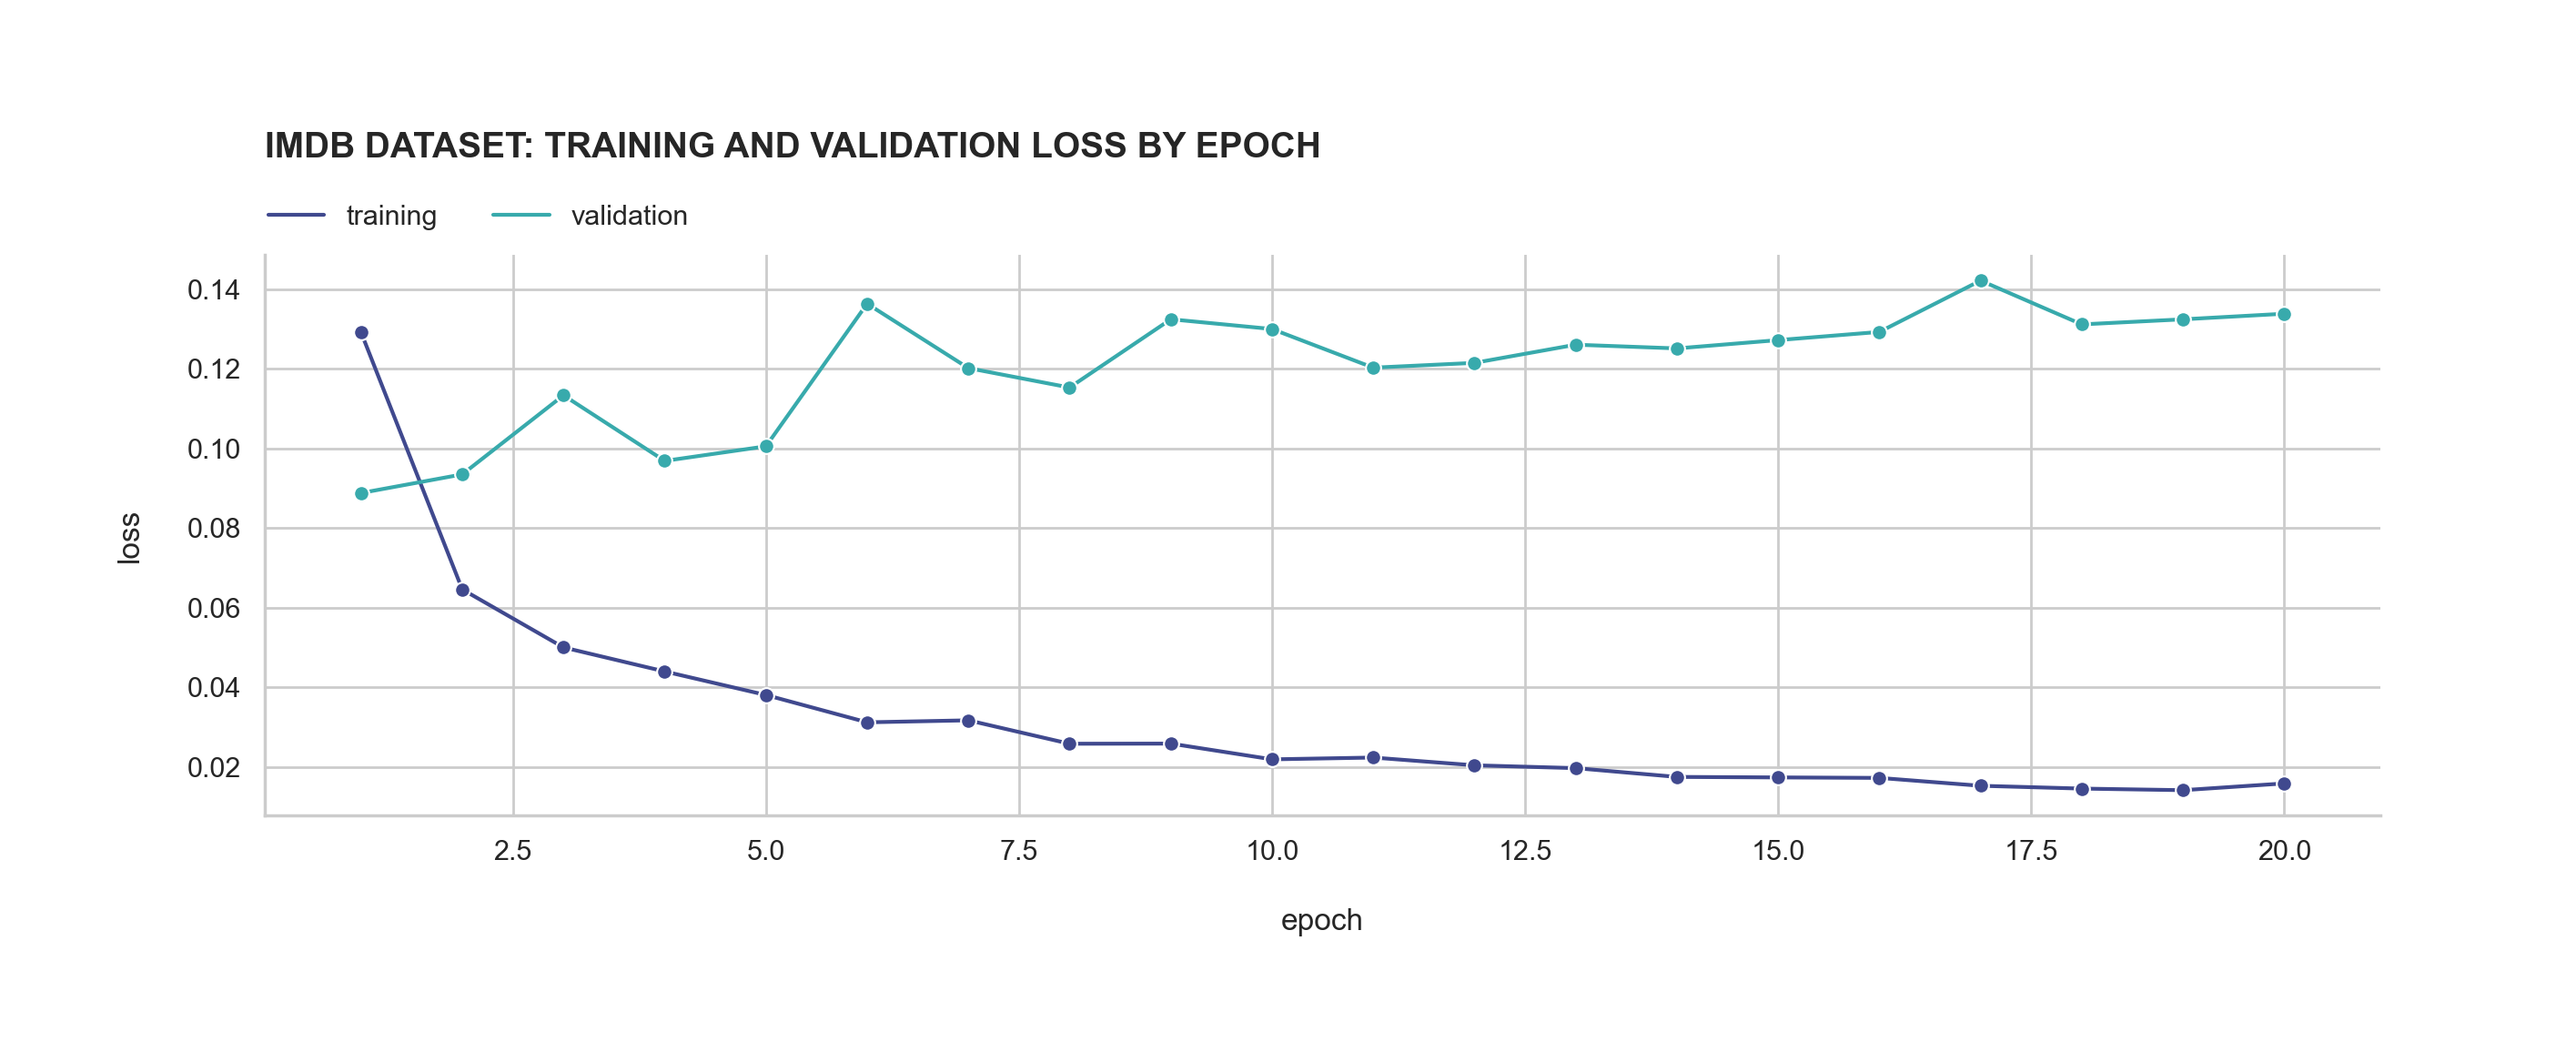

In [62]:
plot_lineplot(
    data = pd.DataFrame(dict(
        epoch = list(range(1, len(history_dict.get('loss')) + 1)) * 2,
        loss = history_dict.get('loss') + history_dict.get('val_loss'),
        set = ('training ' * 20).split() + ('validation ' * 20).split(), )),
    x = 'epoch', y = 'loss', hue = 'set',
    title = 'IMDB Dataset: Training and validation loss by epoch'
);

Training and validation accuracy visualization

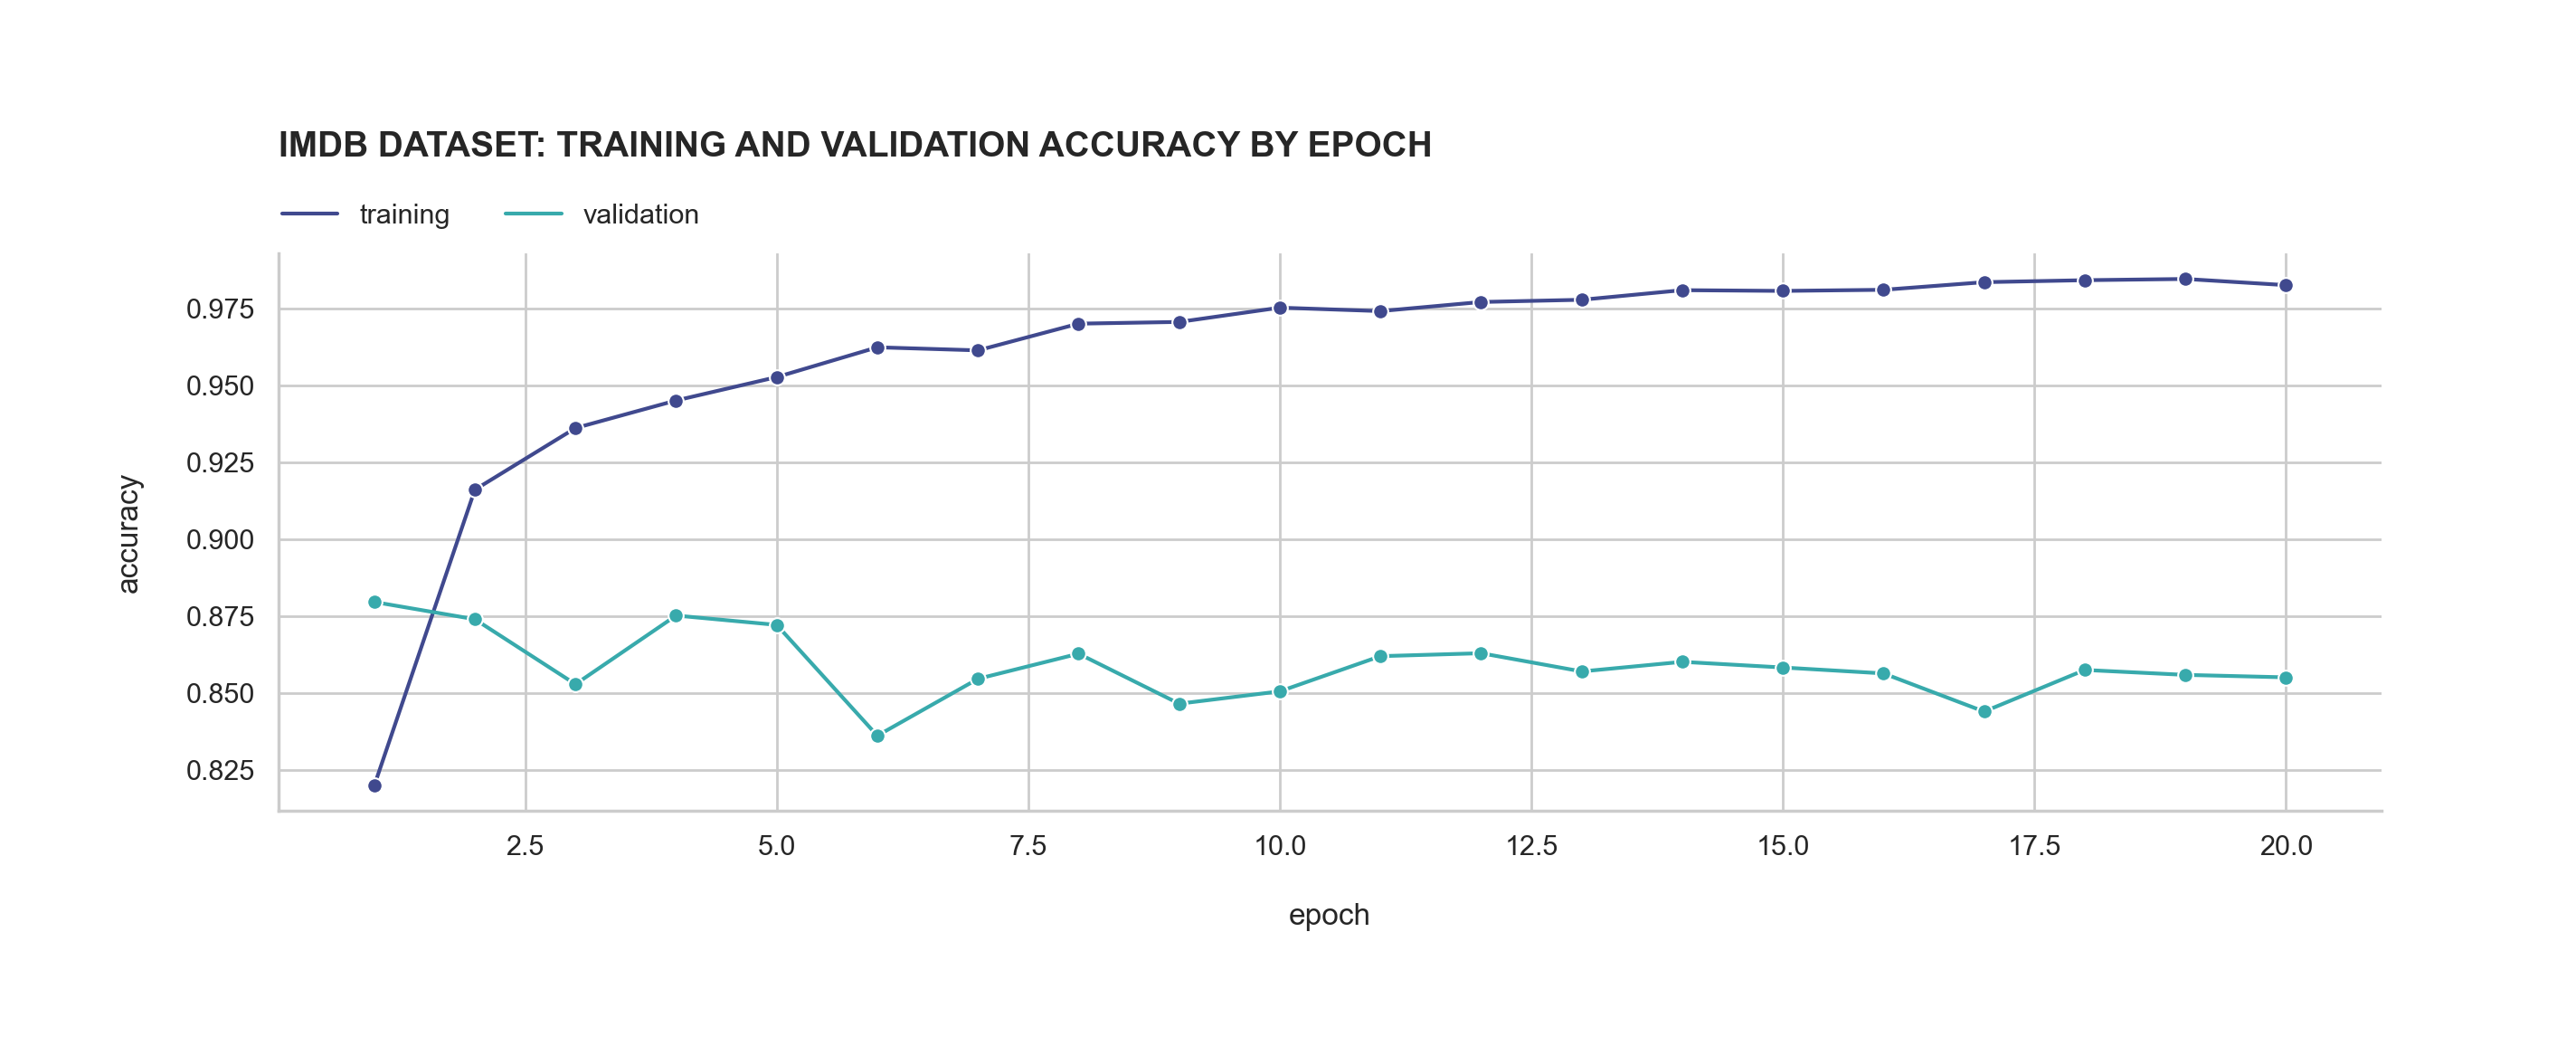

In [65]:
plot_lineplot(
    data = pd.DataFrame(dict(
        epoch = list(range(1, len(history_dict.get('accuracy')) + 1)) * 2,
        accuracy = history_dict.get('accuracy') + history_dict.get('val_accuracy'),
        set = ('training ' * 20).split() + ('validation ' * 20).split(), )),
    x = 'epoch', y = 'accuracy', hue = 'set',
    title = 'IMDB Dataset: Training and validation accuracy by epoch'
);

From the two figures above, the training loss decreases and the training accuracy increases after every epoch which is what should be expected when running gradient descent optimization─the quantity you are trying to minimize should get lower with every iteration.

Points from the figures:
* The validation loss had a strike around the 3rd epoch with a loss value of 0.11 then dipped at the 4th epoch and rising slowly by the 5th epoch with a loss value of 0.10.
* The validation accuracy dipped at the 3rd epoch with a validation accuracy score of around 0.85 then rose at the 4th epoch and slightly dropping at the 5th epoch with an accuracy value of 0.875.

To prevent overfitting, we could simply stop after 5 epochs.

### Retraining the model

In [66]:
model.fit(
    x = var_X_train_vectorized, y = var_y_train_vectorized, epochs = 5, 
    batch_size = 512, validation_data = (var_X_val_vectorized, var_y_val_vectorized), )